In [59]:
from Data.IMDB import IMDB
from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
import dgl
import torch    

In [60]:
imdb = IMDB()
original_graph = imdb.load_graph(n_components=100)
device = "cuda:2"
original_graph = original_graph.to(device)

In [62]:

num_nearest_init_neighbors_per_type = {"actortomovie": 50, "directortomovie": 50, "movietoactor":50, "movietodirector":50, "actor":50, "director":50, "movie":50}
from Projections.ContrastiveLearner import ContrastiveLearner
from Projections.CCA import CCA
coarsener = HeteroRGCNCoarsener(original_graph, num_nearest_init_neighbors_per_type,  checkpoints=[0.3] ,folder_name="imdb_cca_pca_20", cca_cls=CCA,device=device, use_zscore=False, pairs_per_level=20,norm_p=1, approx_neigh=True, add_feat=True, use_out_degree=False) 

coarsener.init()

coarsener.summarize()

/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/dgl/transforms/functional.py:1366: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


actortomovie
directortomovie
movietoactor
movietodirector
step: 0, ratio: 1.0
step: 1, ratio: 0.9990530303030303
step: 2, ratio: 0.9981060606060606
step: 3, ratio: 0.9971590909090909
step: 4, ratio: 0.9962121212121212
step: 5, ratio: 0.9952651515151515
step: 6, ratio: 0.9943181818181818
step: 7, ratio: 0.9933712121212122
step: 8, ratio: 0.9924242424242424
step: 9, ratio: 0.9914772727272727
step: 10, ratio: 0.990530303030303
step: 11, ratio: 0.9895833333333334
step: 12, ratio: 0.9886363636363636
step: 13, ratio: 0.9876893939393939
step: 14, ratio: 0.9867424242424242
step: 15, ratio: 0.9857954545454546
step: 16, ratio: 0.9848484848484849
step: 17, ratio: 0.9839015151515151
step: 18, ratio: 0.9829545454545454
step: 19, ratio: 0.9820075757575758
step: 20, ratio: 0.9810606060606061
step: 21, ratio: 0.9801136363636364
step: 22, ratio: 0.9791666666666666
step: 23, ratio: 0.978219696969697
step: 24, ratio: 0.9772727272727273
step: 25, ratio: 0.9763257575757576
step: 26, ratio: 0.97537878787878

In [35]:
X =coarsener.summarized_graph.nodes['movie'].data['feat_pca']
Y = coarsener.summarized_graph.nodes['movie'].data["hmovietoactor"]

In [36]:
import numpy as np
coarsener.summarized_graph.nodes['movie']
X_c, Y_c = coarsener.ccas['movietoactor'].transform(X,Y)
X_c, Y_c = X_c.to('cpu'), Y_c.to('cpu')
canonical_corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(2)]
print("Canonical Correlations:", canonical_corrs)

Canonical Correlations: [0.9764941557679705, 0.9409967251603368]


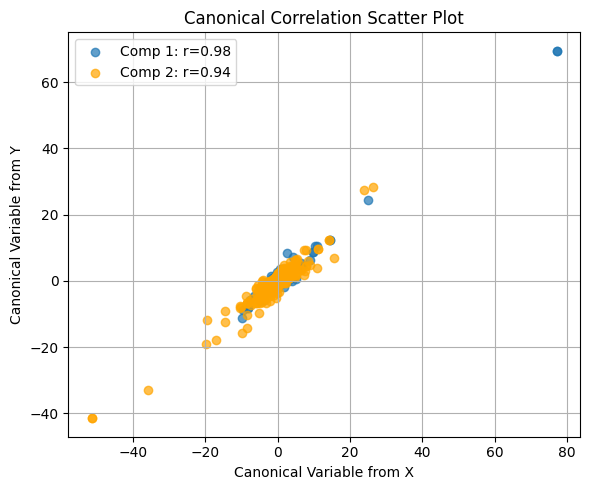

In [37]:

import matplotlib.pyplot as plt
# Scatter plot of canonical variates
plt.figure(figsize=(6, 5))
plt.scatter(X_c[:, 0], Y_c[:, 0], label=f"Comp 1: r={canonical_corrs[0]:.2f}", alpha=0.7)
plt.scatter(X_c[:, 1], Y_c[:, 1], label=f"Comp 2: r={canonical_corrs[1]:.2f}", alpha=0.7, color='orange')
plt.xlabel("Canonical Variable from X")
plt.ylabel("Canonical Variable from Y")
plt.title("Canonical Correlation Scatter Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:

import pickle
with open(f'results/imdb_cl_pca_30/0.3', 'rb') as fh:
        
    coarsener_imdb = pickle.load(fh) 

In [37]:

import pickle
with open(f'results/dblp_cca_pca_30/0.3', 'rb') as fh:
        
    coarsener_dblp = pickle.load(fh) 

In [40]:
coarsener_imdb.cca_cls

Projections.CCA.CCA

In [39]:
coarsener_dblp.feat_in_gcn

False

In [63]:
import torch
coarsend_graph = coarsener.summarized_graph
coarsend_graph = coarsend_graph.to(device)
#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("movie")
coarsener.make_mask(mapping, "movie")

labels = coarsener.get_labels(mapping, "movie")
coarsend_graph.nodes["movie"].data["label"] = torch.tensor([labels[i] for i in range(len(labels)) ],  device=device) #,
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 


ratio 0.2997589531680441


In [ ]:
total_nodes

4278

In [64]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
from Models.HeteroSGC import HeteroSGC
import importlib
from Models.HeteroSage import HeteroSAGE

from Models.HeteroSGC import HeteroSGCPaper
from Experiments.model_helper import run_experiments
from Experiments.plots import plot_bar, plot_line
orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,   HeteroSGC, num_runs=1,
                                                  model_param={"hidden_dim": 64,"num_layers":4,} ,
                        optimizer_param={"lr": 0.003, "weight_decay": 5e-4}, epochs=200,eval_interval=1, target_node_type="movie", device="cuda:2")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]


In [65]:
max(orig[0]), max(coar[0])

(0.691948658109685, 0.6242707117852976)

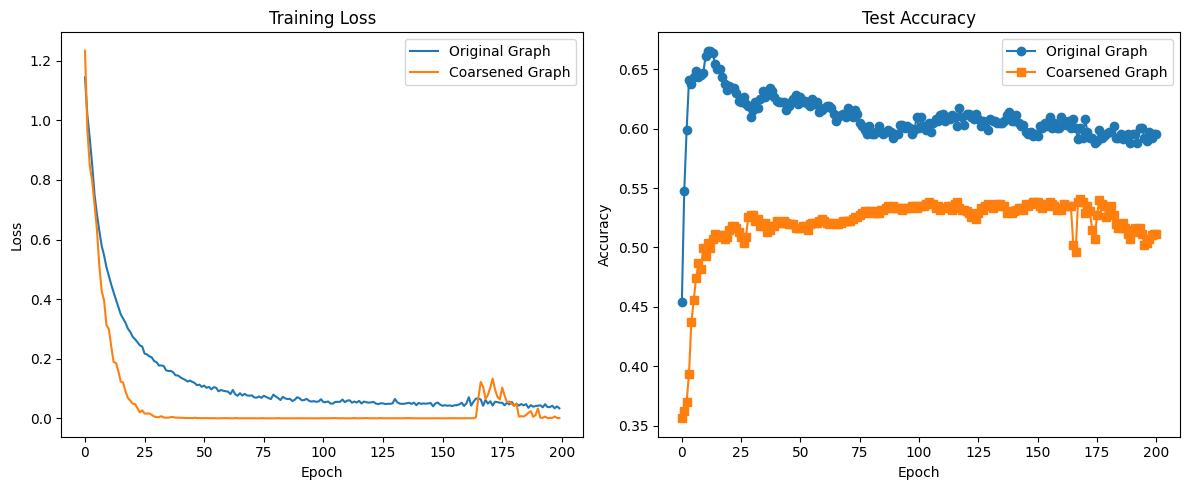

Final Performance Comparison:
Original Graph Accuracy: 0.5956
Coarsened Graph Accuracy: 0.5117

Original Graph Accuracy:
  Mean: 0.5956
  Std:  0.0000

Coarsened Graph Accuracy:
  Mean: 0.5117
  Std:  0.0000


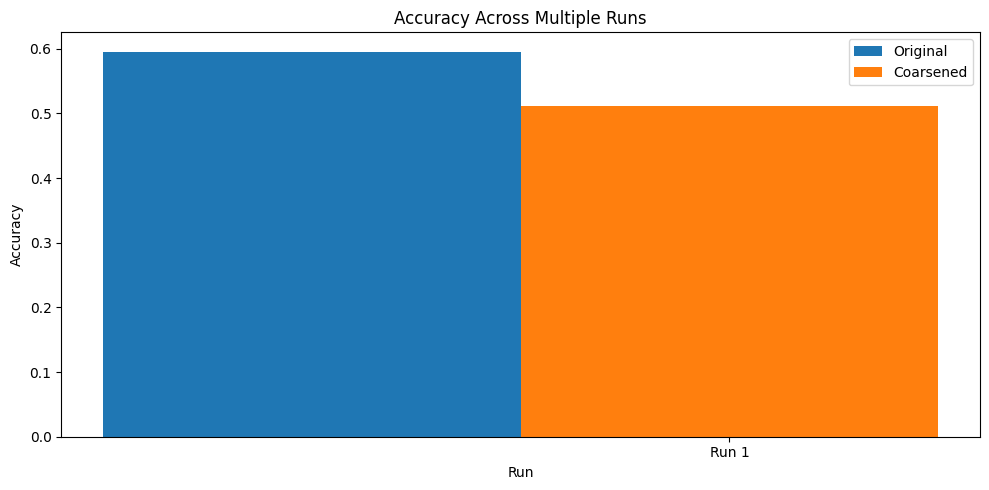

In [58]:
from Experiments.plots import plot_bar, plot_line

epochs = list(range(200))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
plot_bar(orig_short, coar_short)

TypeError: can't convert cuda:1 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

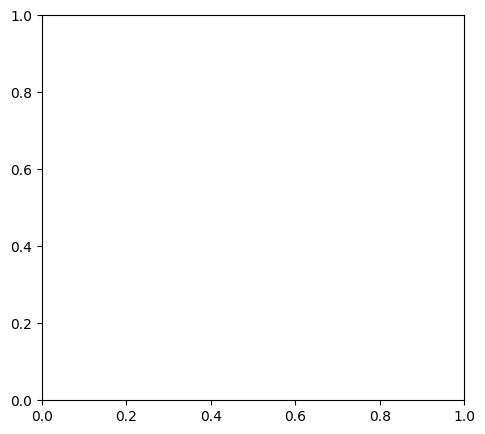

In [ ]:
epochs = torch.tensor(epochs, device=device)
